In [1]:
import torch
from heat_solver import HeatSolver, get_boundary_conditions
from inverse_solver import InverseSolver
from utils import (
    create_conductivity_field,
    sine_cosine_source,
    r2_score,
    nrmse_score
)
from utils import SimpleSigma, SigmoidSigma

from utils import visualize_solution, plot_comparison

import numpy as np
import matplotlib.pyplot as plt

In [2]:
M = 10
T = 1.0
max_sigma = 5
alpha = 0.001
sigma_0 = 1.0
omega = 2 * np.pi
lr = 0.1
noise_level = 0.001
max_iters = 50
tol = 5e-2
pattern = "linear"
device = "cpu"

In [3]:
sigma_gt = create_conductivity_field(M, pattern=pattern, device=device)
source_func = lambda x, y, t: 10 * sine_cosine_source(x, y, t, omega, device)

# Generate boundary observations with noise
u_b_gt = get_boundary_conditions(sigma_gt, source_func, T, max_sigma, device=device)
u_b = (1 + noise_level * torch.randn_like(u_b_gt)) * u_b_gt

sigma_module = SimpleSigma(M, sigma_0)

In [4]:
# One solver run to balance losses
sigma = sigma_module()

mape = torch.abs((sigma - sigma_gt) / sigma_gt).mean().item()
rmse = (sigma - sigma_gt).square().mean().sqrt().item()
nrmse = rmse / sigma_gt.square().mean().sqrt().item()
print(f'MAPE: {mape:.3f}; RMSE: {rmse:.3f}; NRMSE: {nrmse:.4f}')
print('R2: ', r2_score(sigma, sigma_gt))

solver = HeatSolver(M, source_func, device)
_, u_b_history, u_history = solver(sigma, T, max_sigma=max_sigma)

reg_loss = solver.h**2 * (sigma - sigma_0).square().sum().item()
data_loss = solver.h * solver.tau * (u_b_history - u_b).square().sum().item()
alpha = 0.01 * data_loss / reg_loss
print(alpha, data_loss, reg_loss)

nrmse = nrmse_score(u_b_history, u_b)
r2 = r2_score(u_b_history, u_b)
print(nrmse, r2)

MAPE: 0.470; RMSE: 1.071; NRMSE: 0.5246
R2:  -5.946561336517334
0.14948752650085517 0.13366055908203126 0.008941251635551454
0.4854576587677002 0.21523761749267578


In [5]:
# Inverse solver
inverse_solver = InverseSolver(
    sigma_module,
    u_b_gt=u_b,
    source_func=source_func,
    M=M,
    T=T,
    n_steps=u_b.shape[0] - 1,
    lr=lr,
    alpha=alpha,
    sigma_0=sigma_0,
    max_grad_norm=1.0,
    device=device,
)

(
    final_sigma,
    logs
) = inverse_solver.solve(
    max_iters=max_iters,
    tol=tol,
    early_stopping=True,
    patience=10,
    early_stopping_delta=0.0001,
    print_info=False
)

  2%|▏         | 1/50 [00:09<07:52,  9.64s/it]

Iter 0: Loss = 0.134997; nrmse=0.485458; R2: 0.21524


  4%|▍         | 2/50 [00:19<07:45,  9.69s/it]

Iter 1: Loss = 0.093902; nrmse=0.438327; R2: 0.46675


  6%|▌         | 3/50 [00:29<07:34,  9.68s/it]

Iter 2: Loss = 0.070011; nrmse=0.394296; R2: 0.63200


  8%|▊         | 4/50 [00:39<07:36,  9.92s/it]

Iter 3: Loss = 0.057482; nrmse=0.354386; R2: 0.74024


 10%|█         | 5/50 [00:49<07:24,  9.87s/it]

Iter 4: Loss = 0.051972; nrmse=0.319175; R2: 0.81132


 12%|█▏        | 6/50 [00:58<07:13,  9.84s/it]

Iter 5: Loss = 0.050436; nrmse=0.288820; R2: 0.85838


 14%|█▍        | 7/50 [01:08<07:01,  9.81s/it]

Iter 6: Loss = 0.050871; nrmse=0.263218; R2: 0.88982


 16%|█▌        | 8/50 [01:18<06:52,  9.82s/it]

Iter 7: Loss = 0.052041; nrmse=0.242215; R2: 0.91092


 18%|█▊        | 9/50 [01:28<06:42,  9.82s/it]

Iter 8: Loss = 0.053239; nrmse=0.225724; R2: 0.92488


 20%|██        | 10/50 [01:38<06:32,  9.80s/it]

Iter 9: Loss = 0.054113; nrmse=0.213729; R2: 0.93367


 22%|██▏       | 11/50 [01:47<06:22,  9.82s/it]

Iter 10: Loss = 0.054539; nrmse=0.206185; R2: 0.93847


 24%|██▍       | 12/50 [01:57<06:12,  9.80s/it]

Iter 11: Loss = 0.054534; nrmse=0.202907; R2: 0.94003


 26%|██▌       | 13/50 [02:07<06:01,  9.76s/it]

Iter 12: Loss = 0.054181; nrmse=0.203485; R2: 0.93885


 28%|██▊       | 14/50 [02:17<05:52,  9.80s/it]

Iter 13: Loss = 0.053583; nrmse=0.207254; R2: 0.93534


 30%|███       | 15/50 [02:27<05:43,  9.82s/it]

Iter 14: Loss = 0.052828; nrmse=0.213360; R2: 0.92993


 32%|███▏      | 16/50 [02:36<05:32,  9.79s/it]

Iter 15: Loss = 0.051983; nrmse=0.220909; R2: 0.92311


 34%|███▍      | 17/50 [02:46<05:21,  9.74s/it]

Iter 16: Loss = 0.051099; nrmse=0.229131; R2: 0.91537


 36%|███▌      | 18/50 [02:56<05:12,  9.77s/it]

Iter 17: Loss = 0.050214; nrmse=0.237476; R2: 0.90716


 38%|███▊      | 19/50 [03:06<05:02,  9.75s/it]

Iter 18: Loss = 0.049371; nrmse=0.245627; R2: 0.89880


 40%|████      | 20/50 [03:15<04:52,  9.75s/it]

Iter 19: Loss = 0.048614; nrmse=0.253437; R2: 0.89050


 42%|████▏     | 21/50 [03:25<04:42,  9.74s/it]

Iter 20: Loss = 0.047986; nrmse=0.260842; R2: 0.88240


 44%|████▍     | 22/50 [03:35<04:31,  9.71s/it]

Iter 21: Loss = 0.047516; nrmse=0.267790; R2: 0.87463


 46%|████▌     | 23/50 [03:44<04:23,  9.74s/it]

Iter 22: Loss = 0.047210; nrmse=0.274193; R2: 0.86734


 48%|████▊     | 24/50 [03:54<04:12,  9.72s/it]

Iter 23: Loss = 0.047049; nrmse=0.279928; R2: 0.86071


 50%|█████     | 25/50 [04:04<04:03,  9.73s/it]

Iter 24: Loss = 0.046993; nrmse=0.284853; R2: 0.85496


 52%|█████▏    | 26/50 [04:13<03:52,  9.69s/it]

Iter 25: Loss = 0.046992; nrmse=0.288838; R2: 0.85028


 54%|█████▍    | 27/50 [04:23<03:42,  9.65s/it]

Iter 26: Loss = 0.046998; nrmse=0.291793; R2: 0.84684


 56%|█████▌    | 28/50 [04:33<03:33,  9.71s/it]

Iter 27: Loss = 0.046973; nrmse=0.293678; R2: 0.84470


 56%|█████▌    | 28/50 [04:42<03:42, 10.11s/it]

Early stopping at iteration 28
Loss = 0.046896; nrmse=0.294517; R2: 0.84386


In [6]:
mape = torch.abs((final_sigma - sigma_gt) / sigma_gt).mean().item()
rmse = (final_sigma - sigma_gt).square().mean().sqrt().item()
print(f'MAPE: {mape:.3f}; MSE: {rmse:.3f}')

print('R2: ', r2_score(final_sigma, sigma_gt))

MAPE: 0.318; MSE: 0.775
R2:  -2.6367805004119873


In [7]:
total_loss_history = logs['total_loss_history']
boundary_loss_history = logs['boundary_loss_history']
regularization_loss_history = logs['regularization_loss_history']
grad_norm_history = logs['gradient_norm_history']

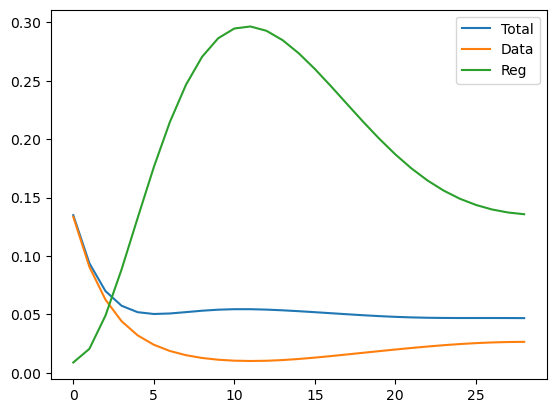

In [8]:
plt.plot(total_loss_history, label='Total')
plt.plot(boundary_loss_history, label='Data')
plt.plot(regularization_loss_history, label='Reg')
plt.legend()
plt.show()

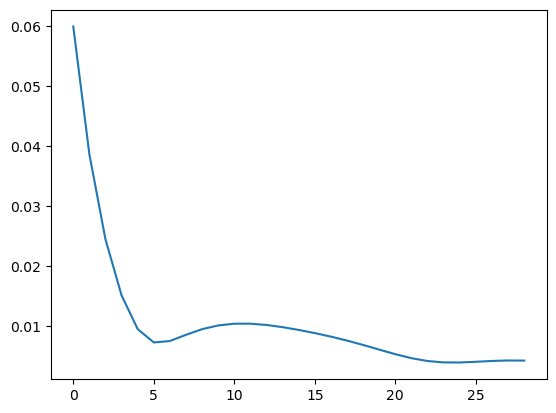

In [9]:
plt.plot(grad_norm_history)
plt.show()

In [13]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

In [ ]:
def plot_comparison(x, y, pred, real):
    error = pred - real

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Numerical solution
    im1 = axes[0, 0].contourf(
        x.detach().numpy(),
        y.detach().numpy(),
        pred.detach().numpy(),
        levels=20,
        cmap="viridis",
    )
    axes[0, 0].set_title("Numerical Solution")
    axes[0, 0].set_xlabel("x")
    axes[0, 0].set_ylabel("y")
    axes[0, 0].set_aspect("equal")
    plt.colorbar(im1, ax=axes[0, 0], label="Temperature")

    # Analytical solution
    im2 = axes[0, 1].contourf(
        x.detach().numpy(),
        y.detach().numpy(),
        real.detach().numpy(),
        levels=20,
        cmap="viridis",
    )
    axes[0, 1].set_title("Analytical Solution")
    axes[0, 1].set_xlabel("x")
    axes[0, 1].set_ylabel("y")
    axes[0, 1].set_aspect("equal")
    plt.colorbar(im2, ax=axes[0, 1], label="Temperature")

    # Error
    im3 = axes[1, 0].contourf(
        x.detach().numpy(),
        y.detach().numpy(),
        error.detach().numpy(),
        levels=20,
        cmap="RdBu_r",
    )
    axes[1, 0].set_title("Error (Numerical - Analytical)")
    axes[1, 0].set_xlabel("x")
    axes[1, 0].set_ylabel("y")
    axes[1, 0].set_aspect("equal")
    plt.colorbar(im3, ax=axes[1, 0], label="Error")

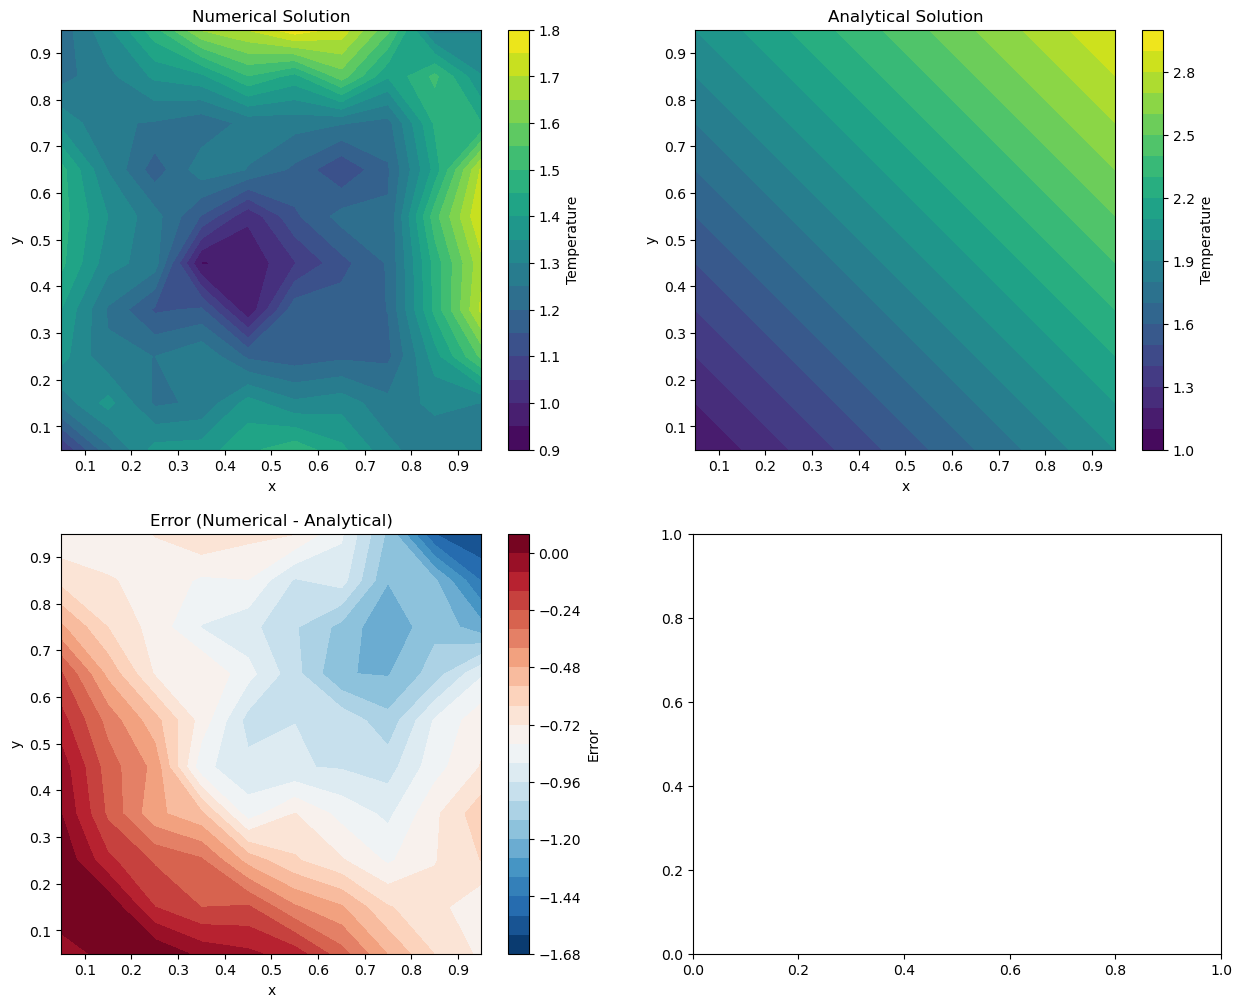

In [12]:
plot_comparison(X, Y, final_sigma, sigma_gt)